# Fine-tuning R-CNN

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import numpy as np
import matplotlib.pyplot as plt

## Import data

In [2]:
from src.detection_utils import DetectionDataset

base_dir = './object_detection/'
cd = DetectionDataset(base_dir, None)

In [3]:
import torch
from src import detection_utils

# use our dataset and defined transformations
dataset = DetectionDataset('./object_detection/', None)
dataset_test = DetectionDataset('./object_detection/', None)

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=detection_utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=detection_utils.collate_fn)

## Build model

We use pytorch implementation of FasterRCNN. The FasterRCNN (and MaskRCNN) is implemented with the following structure:

- model
    - transform
    - backbone
        - body (ResNet50)
        - feature pyramid network
    - region proposal network
        - AnchorGenerator
        - RPNHead
            - cls_logits
            - bbox_pred
    - ROIHeads
        - MultiScaleROIAlign
        - TwoMLPHead
        - FastRCNNPredictor
            - cls_score
            - bbox_pred
        - MaskRCNNHeads
        - MaskRCNNPredictor
            - mask_fcn_logits

In [4]:
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

model_name = 'fasterrcnn'  # 'maskrcnn'

nb_classes = 3  # including background

# load an instance segmentation model pre-trained on COCO
if model_name == 'fasterrcnn':
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
else:
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

# get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, nb_classes)

if model_name == 'maskrcnn':

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256

    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       nb_classes)

## Model training - fine tune

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0001,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [6]:
from src.engine import train_one_epoch, evaluate

nb_epochs = 5

for epoch in range(nb_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)
    
# save model
save_path = './weights/rcnn_%02depochs.torch' % nb_epochs
torch.save(model.state_dict(), save_path)

## Model evaluation

In [7]:
from src.utils import get_files, get_data

base_dir = '/Users/jcboyd/Dropbox/test_crops/'

experiment = 'raji_target'
days = 3

train_imgs, _, test_imgs = get_files(base_dir, experiment, days)
# test_imgs = train_imgs

Using TensorFlow backend.


No. train images: 36
No. val images: 0
No. test images: 36


In [8]:
from src.utils import import_annotations

annotations_dir = './zenodo/test/labels/'
plate = 'VID193_A5_4'

arr_num_dead, arr_num_raji, gt_b_masks, gt_d_masks = import_annotations(annotations_dir, plate)

/Users/jcboyd/Desktop/tracking-lympochytes/src/utils.py:229: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 229 of the file /Users/jcboyd/Desktop/tracking-lympochytes/src/utils.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  soup = BeautifulSoup(fp)


In [9]:
# load model
nb_epochs = 5
save_path = './weights/rcnn_%02depochs.torch' % nb_epochs

model.load_state_dict(torch.load(save_path, map_location=torch.device('cpu')))
model = model.eval()

In [10]:
from skimage.io import imread

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

file_path = os.path.join(base_dir, 'phase_contrast', test_imgs[0])
img = imread(file_path) / 255.

img = torch.tensor(img[None, ...]).float()

with torch.no_grad():
    prediction = model([img.to(device)])

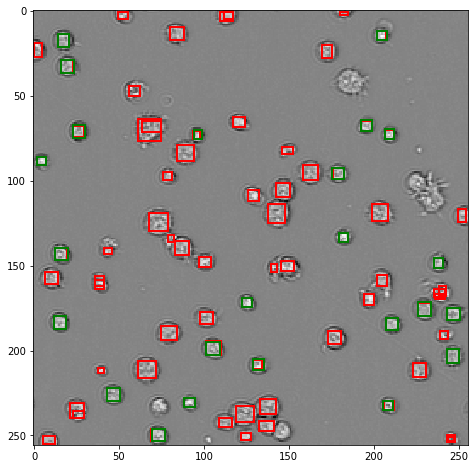

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))

plt_img = img.mul(255).permute(1, 2, 0).byte().numpy().squeeze()

ax.imshow(plt_img, cmap='Greys')

for i, bb in enumerate(prediction[0]['boxes']):

    x_min, y_min, x_max, y_max = bb

    cls = prediction[0]['labels'][i].item()
    colour = 'red' if cls == 1 else 'green'

    rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                          linewidth=2, edgecolor=colour, facecolor='none')
    ax.add_patch(rect)

In [12]:
from src.utils import create_masks

b_masks, d_masks = [], []
b_counts, d_counts = [], []

for file_name in test_imgs:
    file_path = os.path.join(base_dir, 'phase_contrast', file_name)

    img = imread(os.path.join(file_path)) / 255.
    img = torch.tensor(img[None, ...]).float()
    
    h, w = img.shape[1:]

    with torch.no_grad():
        prediction = model([img.to(device)])

    detections = prediction[0]['boxes'].numpy()
    classes = prediction[0]['labels'].numpy()
    
    b_centers, d_centers = [], []

    for i, bbs in enumerate(detections):
        y_min, x_min, y_max, x_max = bbs
        cls = classes[i]

        if cls == 1:
            b_centers.append([int((y_max + y_min) / 2), int((x_max + x_min) / 2)])
        else:
            d_centers.append([int((y_max + y_min) / 2), int((x_max + x_min) / 2)])

    b_centers = np.array(b_centers)
    d_centers = np.array(d_centers)

    b_counts.append(b_centers.shape[0])
    d_counts.append(d_centers.shape[0])

    b_mask, d_mask = create_masks(h, w, b_centers, d_centers)

    b_masks.append(b_mask)
    d_masks.append(d_mask)

In [13]:
N = len(arr_num_raji)

mean_count_err_raji = np.mean(np.abs(np.array(b_counts) - arr_num_raji[:N]))
mean_count_err_dead = np.mean(np.abs(np.array(d_counts) - arr_num_dead[:N]))

mean_perc_err_raji = np.mean(np.abs(np.array(b_counts) - arr_num_raji[:N]) / arr_num_raji[:N])
mean_perc_err_dead = np.mean(np.abs(np.array(d_counts) - arr_num_dead[:N]) / arr_num_dead[:N])

print('Mean err. RAJI %.04f' % mean_count_err_raji)
print('Mean err. Dead %.04f' % mean_count_err_dead)

print('Mean perc err. RAJI %.04f' % mean_perc_err_raji)
print('Mean perc err. Dead %.04f' % mean_perc_err_dead)

Mean err. RAJI 37.0000
Mean err. Dead 41.2500
Mean perc err. RAJI 0.7667
Mean perc err. Dead 0.7510


In [14]:
from src.utils import evaluate

b_tps_list, b_fps_list, b_fns_list = [], [], []
d_tps_list, d_fps_list, d_fns_list = [], [], []

for i in range(N):
    tps, fps, fns = evaluate(gt_b_masks[i], b_masks[i], max_dist=10)
    b_tps_list.append(tps)
    b_fps_list.append(fps)
    b_fns_list.append(fns)

    tps, fps, fns = evaluate(gt_d_masks[i], d_masks[i], max_dist=10)
    d_tps_list.append(tps)
    d_fps_list.append(fps)
    d_fns_list.append(fns)

In [15]:
from src.utils import calculate_recall, calculate_precision, calculate_f1

tps = np.sum(b_tps_list)
fps = np.sum(b_fps_list)
fns = np.sum(b_fns_list)

precision = calculate_precision(tps, fps)
recall = calculate_recall(tps, fns)
f1 = calculate_f1(precision, recall)

print('Precision %.04f Recall %0.4f F1 %.04f' % (precision, recall, f1))

Precision 0.2604 Recall 0.3446 F1 0.2967


In [16]:
tps = np.sum(d_tps_list)
fps = np.sum(d_fps_list)
fns = np.sum(d_fns_list)

precision = calculate_precision(tps, fps)
recall = calculate_recall(tps, fns)
f1 = calculate_f1(precision, recall)

print('Precision %.04f Recall %0.4f F1 %.04f' % (precision, recall, f1))

Precision 0.1689 Recall 0.0571 F1 0.0854


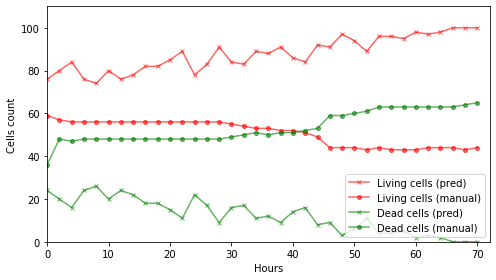

In [17]:
fig, ax = plt.subplots(figsize=(7, 4))

x_range = range(0, 2 * N, 2)

ax.set_xlim([0, 72])
ax.set_ylim([0, 110])

ax.plot(x_range, np.array(b_counts), marker='x', markersize=4,
        color='Red', label='Living cells (pred)', alpha=0.6)
ax.plot(x_range, arr_num_raji, marker='o', markersize=4,
        color='Red', label='Living cells (manual)', alpha=0.6)
ax.plot(x_range, np.array(d_counts), marker='x', markersize=4,
        color='Green', label='Dead cells (pred)', alpha=0.6)
ax.plot(x_range, arr_num_dead, marker='o', markersize=4,
        color='Green', label='Dead cells (manual)', alpha=0.6)

ax.set_xlabel('Hours')
ax.set_ylabel('Cells count')

plt.tight_layout()
plt.legend()

plt.show()